<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[2025-06-18 13:36:56] Starting 2x2 warming decomposition plot generation...
[2025-06-18 13:36:56] Processing Ts = 280.0 K...
[2025-06-18 13:36:57] Processing Ts = 281.0 K...
[2025-06-18 13:36:57] Processing Ts = 282.0 K...
[2025-06-18 13:36:57] Processing Ts = 283.0 K...
[2025-06-18 13:36:57] Processing Ts = 284.0 K...
[2025-06-18 13:36:57] Processing Ts = 285.0 K...
[2025-06-18 13:36:57] Processing Ts = 286.0 K...
[2025-06-18 13:36:57] Processing Ts = 287.0 K...
[2025-06-18 13:36:57] Processing Ts = 288.0 K...
[2025-06-18 13:36:58] Processing Ts = 289.0 K...
[2025-06-18 13:36:58] Processing Ts = 290.0 K...
[2025-06-18 13:36:58] Processing Ts = 291.0 K...
[2025-06-18 13:36:58] Processing Ts = 292.0 K...
[2025-06-18 13:36:58] Processing Ts = 293.0 K...
[2025-06-18 13:36:58] Processing Ts = 294.0 K...
[2025-06-18 13:36:58] Processing Ts = 295.0 K...
[2025-06-18 13:36:59] Processing Ts = 296.0 K...
[2025-06-18 13:36:59] Processing Ts = 297.0 K...
[2025-06-18 13:36:59] Processing Ts = 298.

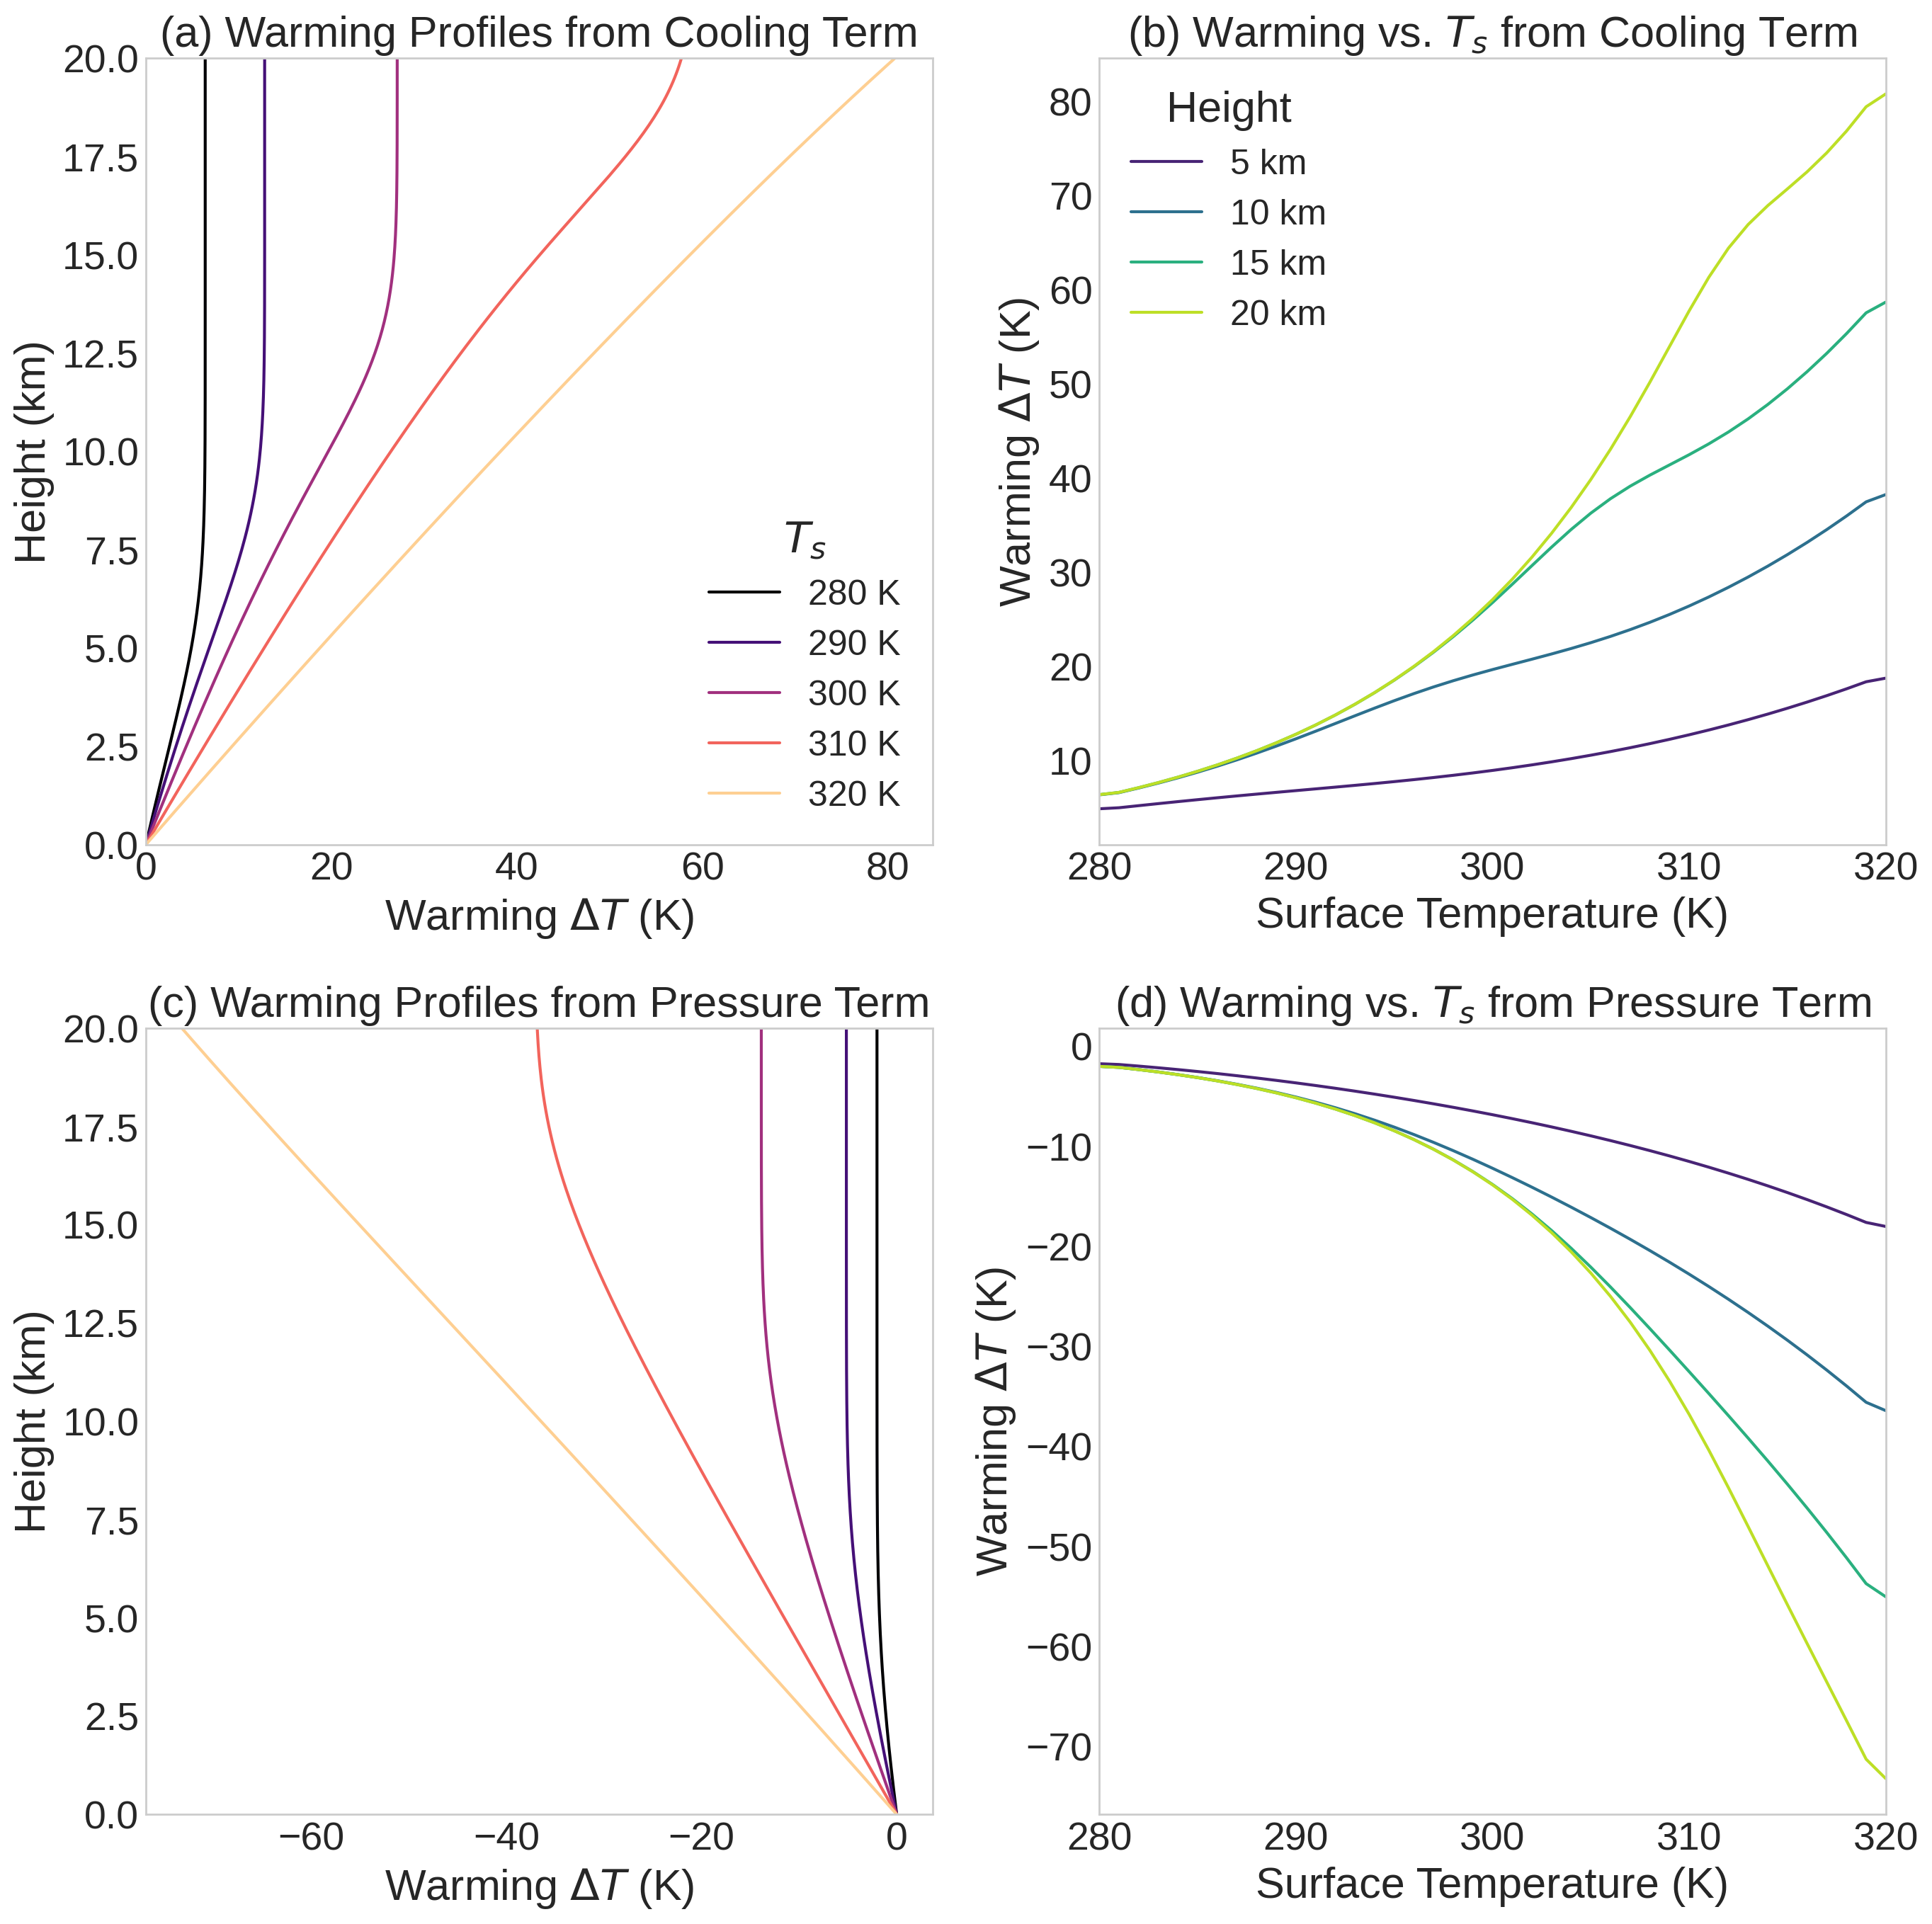

Figure 3 saved as figure_3_warming_decomposition_final.png


In [1]:
# ==============================================================================
# SCRIPT TO CREATE FIGURE 3:
# DECOMPOSITION OF THE WARMING PROFILE
#
# This script translates the lapse rate sensitivity components into their
# respective contributions to the vertical warming profile, ΔT(z), and plots
# the results.
#
# The change in the vertical temperature profile is approximated by the
# negative integral of the lapse rate sensitivity, scaled by the surface
# warming perturbation (ΔT_surf):
# ΔT(z) ≈ - [ ∫[0, z] (dΓm/dTs) dz' ] * ΔT_surf
#
# This script creates a four-panel figure to explore this relationship:
# Top Row: Warming contributions from the "Cooling Term" only.
#  (a) Vertical profiles of warming for different Ts values.
#  (b) Warming at fixed heights as a function of Ts.
# Bottom Row: Warming contributions from the "Pressure Term" only.
#  (c) Vertical profiles of warming for different Ts values.
#  (d) Warming at fixed heights as a function of Ts.
# ==============================================================================

# For sharper inline plots in Jupyter environments
try:
    get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
except (NameError, AttributeError):
    pass

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv_const = 2.501e6

# --- Core Thermodynamic & Profile Functions ---

def saturation_vapor_pressure(T):
    """Calculates saturation vapor pressure (es) in Pa."""
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) in kg/kg."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    denominator = np.maximum(denominator, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def dq_dT_p(p, T):
    """Numerically calculates the partial derivative (dq_s/dT)_p."""
    delta_T = 0.01
    return (saturation_specific_humidity(p, T + delta_T) - saturation_specific_humidity(p, T - delta_T)) / (2 * delta_T)

def dq_dp_T(p, T):
    """Numerically calculates the partial derivative (dq_s/dp)_T."""
    delta_p = 10.0
    return (saturation_specific_humidity(p + delta_p, T) - saturation_specific_humidity(p - delta_p, T)) / (2 * delta_p)

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) in K."""
    qs = saturation_specific_humidity(p, T)
    return T * (1.0 + (1.0 / epsilon - 1.0) * qs)

def calculate_mse(T, p, z):
    """Calculates Moist Static Energy (MSE) in J/kg."""
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv_const * qs

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz):
    """Calculates z, T, and p profiles by conserving MSE."""
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile, p_profile = np.full(n_steps, np.nan), np.full(n_steps, np.nan)
    T_profile[0], p_profile[0] = T_surf, p_surf
    mse_conserved = calculate_mse(T_profile[0], p_profile[0], 0.0)
    for i in range(n_steps - 1):
        z_c, T_c, p_c = z_profile[i], T_profile[i], p_profile[i]
        if np.isnan(T_c) or p_c <= 0: break
        z_n, Tv_c = z_profile[i+1], virtual_temperature(T_c, p_c)
        H = (Rd * Tv_c) / g
        p_n = p_c * np.exp(-dz / H)
        if p_n <= 0: break
        try:
            sol = root_scalar(lambda T_g: calculate_mse(T_g, p_n, z_n) - mse_conserved, bracket=[50.0, T_c + 5], method='brentq')
            if sol.converged: T_profile[i+1], p_profile[i+1] = sol.root, p_n
            else: break
        except (ValueError, RuntimeError): break
    valid = ~np.isnan(T_profile)
    return z_profile[valid], T_profile[valid], p_profile[valid]

def get_sensitivity_components(t_surf_k, p_surf_pa, z_max, dz):
    """Calculates the cooling and pressure components of dqs/dz."""
    z_base, t_base, p_base = calculate_moist_adiabatic_profile(t_surf_k, p_surf_pa, z_max, dz)
    if len(z_base) < 2: return z_base, None, None
    Tv_base = virtual_temperature(t_base, p_base)
    rho_base = p_base / (Rd * Tv_base)
    gamma_m_base = -np.gradient(t_base, z_base[1] - z_base[0])
    cooling_comp_profile = -gamma_m_base * dq_dT_p(p_base, t_base)
    pressure_comp_profile = -rho_base * g * dq_dp_T(p_base, t_base)
    return z_base, cooling_comp_profile, pressure_comp_profile

def main():
    """Main function to execute the calculation and plotting."""
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting 2x2 warming decomposition plot generation...")

    # --- Parameters ---
    P_SURFACE_PA = 100000.0
    Z_MAX_M = 20000
    DZ_M = 100
    T_surf_range_K = np.arange(280, 320.1, 1.0)
    DELTA_T_SURF = 4.0
    z_grid_m = np.arange(0, Z_MAX_M + DZ_M, DZ_M)
    z_grid_km = z_grid_m / 1000.0

    # --- Calculate Sensitivity Grids ---
    cooling_comp_grid = np.full((len(z_grid_m), len(T_surf_range_K)), np.nan)
    pressure_comp_grid = np.full((len(z_grid_m), len(T_surf_range_K)), np.nan)

    for i, t_surf_k in enumerate(T_surf_range_K):
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Processing Ts = {t_surf_k:.1f} K...")
        z, cooling, pressure = get_sensitivity_components(t_surf_k, P_SURFACE_PA, Z_MAX_M, DZ_M)
        if len(z) > 1:
            cooling_comp_grid[:, i] = interp1d(z, cooling, bounds_error=False, fill_value=np.nan)(z_grid_m)
            pressure_comp_grid[:, i] = interp1d(z, pressure, bounds_error=False, fill_value=np.nan)(z_grid_m)

    d_cooling_comp_dT = np.gradient(cooling_comp_grid, T_surf_range_K, axis=1)
    d_pressure_comp_dT = np.gradient(pressure_comp_grid, T_surf_range_K, axis=1)

    cooling_term_sens = (Lv_const / cpd) * d_cooling_comp_dT
    pressure_term_sens = (Lv_const / cpd) * d_pressure_comp_dT

    # --- Calculate Warming Profiles from Sensitivity ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Integrating grids to get warming profiles...")
    delta_T_cooling = -cumulative_trapezoid(cooling_term_sens, z_grid_m, axis=0, initial=0) * DELTA_T_SURF
    delta_T_pressure = -cumulative_trapezoid(pressure_term_sens, z_grid_m, axis=0, initial=0) * DELTA_T_SURF

    # --- Visualization ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Calculation complete. Generating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    base_fontsize = 22

    cmap_profiles = plt.get_cmap('magma')
    T_plot_indices = [0, 10, 20, 30, 40]
    colors_profiles = cmap_profiles(np.linspace(0, 0.9, len(T_plot_indices)))

    cmap_altitudes = plt.get_cmap('viridis')
    z_levels_km = [5, 10, 15, 20]
    colors_altitudes = cmap_altitudes(np.linspace(0.1, 0.9, len(z_levels_km)))

    # --- Row 1: Cooling Term ---
    ax_cool_prof = axes[0, 0]
    ax_cool_alt = axes[0, 1]
    ax_cool_prof.set_title('(a) Warming Profiles from Cooling Term', fontsize=base_fontsize)
    ax_cool_alt.set_title('(b) Warming vs. $T_{s}$ from Cooling Term', fontsize=base_fontsize)

    for i, t_idx in enumerate(T_plot_indices):
        ax_cool_prof.plot(delta_T_cooling[:, t_idx], z_grid_km, color=colors_profiles[i], label=f'{T_surf_range_K[t_idx]:.0f} K')

    for i, z_km in enumerate(z_levels_km):
        z_idx = np.argmin(np.abs(z_grid_km - z_km))
        ax_cool_alt.plot(T_surf_range_K, delta_T_cooling[z_idx, :], color=colors_altitudes[i], label=f'{z_km} km')

    # --- Row 2: Pressure Term ---
    ax_pres_prof = axes[1, 0]
    ax_pres_alt = axes[1, 1]
    ax_pres_prof.set_title('(c) Warming Profiles from Pressure Term', fontsize=base_fontsize)
    ax_pres_alt.set_title('(d) Warming vs. $T_{s}$ from Pressure Term', fontsize=base_fontsize)

    for i, t_idx in enumerate(T_plot_indices):
        ax_pres_prof.plot(delta_T_pressure[:, t_idx], z_grid_km, color=colors_profiles[i])

    for i, z_km in enumerate(z_levels_km):
        z_idx = np.argmin(np.abs(z_grid_km - z_km))
        ax_pres_alt.plot(T_surf_range_K, delta_T_pressure[z_idx, :], color=colors_altitudes[i])

    # --- Formatting and Labels ---
    ax_cool_prof.set_ylabel('Height (km)', fontsize=base_fontsize)
    ax_cool_prof.set_xlabel('Warming $\Delta T$ (K)', fontsize=base_fontsize)
    ax_cool_prof.legend(title='$T_{s}$', title_fontsize=base_fontsize, fontsize=base_fontsize - 4)
    ax_cool_prof.set_ylim(0, 20)
    ax_cool_prof.set_xlim(left=0)

    ax_cool_alt.set_ylabel('Warming $\Delta T$ (K)', fontsize=base_fontsize)
    ax_cool_alt.set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)
    ax_cool_alt.legend(title='Height', title_fontsize=base_fontsize, fontsize=base_fontsize - 4)
    ax_cool_alt.set_xlim(280, 320)

    ax_pres_prof.set_ylabel('Height (km)', fontsize=base_fontsize)
    ax_pres_prof.set_xlabel('Warming $\Delta T$ (K)', fontsize=base_fontsize)
    ax_pres_prof.set_ylim(0, 20)

    ax_pres_alt.set_ylabel('Warming $\Delta T$ (K)', fontsize=base_fontsize)
    ax_pres_alt.set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)
    ax_pres_alt.set_xlim(280, 320)

    for ax in axes.flatten():
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize - 2)
        ax.grid(False)
        ax.set_box_aspect(1)

    plt.tight_layout(pad=2.0)
    fig3_filename = "fig-3.png"
    plt.savefig(fig3_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure 3 saved as {fig3_filename}")


if __name__ == '__main__':
    main()
